# TSP with Clustering

### Hyperparameters

Choose the number of vertices from the set $\left\{ 10, 20, 30, 50, 100 \right\}$ and specify the number of clusters.

Setting `num_clusters = 'default'` will automatically determine the number of clusters as $\sqrt{\text{num\_vertices}/2}$.

In [1]:
num_vertices = 50
num_clusters = 'default'

### Import Packages

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import time

## Step 1: Greedy Clustering

### Parameters

In [3]:
def set_parameters(num_vertices, num_clusters):
    data_path = f'./data/tsp{num_vertices}_test_concorde.txt'
    if not isinstance(num_clusters, int):
        num_clusters = round((num_vertices * 0.5) ** 0.5)
    return data_path, num_clusters

data_path, num_clusters = set_parameters(num_vertices, num_clusters)

### Define Class `Vertex`

In [4]:
class Vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __str__(self):
        return f"({self.x}, {self.y})"
    
    def __repr__(self):
        return f"({self.x}, {self.y})"
    
    def points(self):
        return [self.x, self.y]
    
    def __lt__(self, other):
        return self.x < other.x if self.x != other.x else self.y < other.y
    
    def distance_to(self, other):
        return ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5

### Read Data

In [5]:
def read_data(data_path, num_repeat, shuffle=True):
    with open(data_path, 'r') as file:
        data = [line.strip() for line in file.readlines()]

        if shuffle:
            random.shuffle(data)
        
        test_cases, optimums = [], []

        for i in range(num_repeat):
            line = data[i].split()
            line, answer = line[:line.index('output')], line[line.index('output')+1:]
            test_case = []
            for j in range(0, len(line), 2):
                test_case.append(Vertex(float(line[j]), float(line[j+1])))
            test_cases.append(test_case)
        
            optimum = []
            for ind in answer:
                ind = int(ind) - 1
                optimum.append(test_case[ind])
            optimums.append(optimum)

        return test_cases, optimums

test_cases, optimums = read_data(data_path, 1)

### Run Greedy Algorithm

In [6]:
def assign_clusters(vertices, selected_vertices):
    assignments = {}
    for v in vertices:
        closest_vertex = min(selected_vertices, key=lambda sv: v.distance_to(sv))
        assignments[v] = closest_vertex
    return assignments

def greedy(vertices, k):
    selected = []
    pick = random_pick(vertices)
    selected.append(pick)
    while len(selected) < k:
        furthest_vertex = max_distance_vertex(vertices, selected)
        vertices.remove(furthest_vertex)
        selected.append(furthest_vertex)
    return selected

def random_pick(vertices):
    pick = random.sample(sorted(vertices), 1)[0]
    vertices.remove(pick)
    return pick

def max_distance_vertex(vertices, picked):
    max_distance = -np.inf
    furthest_vertex = None
    for v in vertices:
        min_distance = min(v.distance_to(p) for p in picked)
        if min_distance > max_distance:
            max_distance = min_distance
            furthest_vertex = v
    return furthest_vertex

def random_vertex(min_value, max_value):
    return Vertex(random.randint(min_value, max_value), random.randint(min_value, max_value))

### Plot Clusters

In [7]:
def plot_clusters(vertices, cluster_assignments, selected_vertices):
    # Assign unique colors for each cluster
    colors = plt.colormaps['tab10' if len(selected_vertices) <= 10 else 'tab20']

    for idx, cluster_id in enumerate(selected_vertices):
        # Get vertices belonging to the current cluster
        cluster_points = [v for v in vertices if cluster_assignments[v] == cluster_id]
        xs = [v.x for v in cluster_points]
        ys = [v.y for v in cluster_points]
        
        # Plot cluster points
        plt.scatter(xs, ys, label=f"Cluster {cluster_id}", color=colors(idx))

        # Plot the cluster center with the same color but a different marker (e.g., square)
        plt.scatter(cluster_id.x, cluster_id.y, color=colors(idx), marker='s', edgecolor='black', s=100)

### Execute

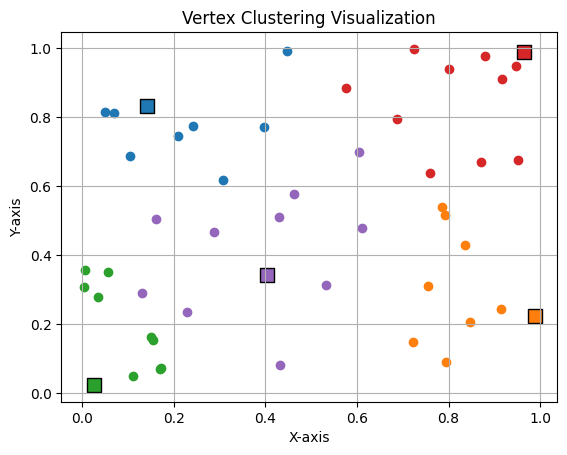

In [8]:
def run_clustering(vertices, num_clusters, show_plot):
    selected_vertices = greedy(vertices, num_clusters)

    # Assign all vertices to the nearest selected vertex
    cluster_assignments = assign_clusters(vertices, selected_vertices)

    if show_plot:
    # Plot clusters
        plot_clusters(vertices, cluster_assignments, selected_vertices)

        plt.title("Vertex Clustering Visualization")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.grid()
        plt.show()

    # Initialize a new dictionary to hold the result
    result_dict = {}

    # Iterate through the original dictionary items
    for key, value in cluster_assignments.items():
        if value not in result_dict:
            result_dict[value] = []  # Create a new list for new keys
        result_dict[value].append(key)  # Append the current key to the list
    
    return vertices, cluster_assignments, selected_vertices

vertices, cluster_assignments, selected_vertices = run_clustering(test_cases[0], num_clusters, True)

## Step 2: TSP on the Cluster Centers and Within Each Cluster

### Traditional TSP Algorithm Using Dynamic Programming and Bit Masking

In [9]:
def tsp_traditional(vertices):
    n = len(vertices)
    # Create a distance matrix
    distance = [[0] * n for _ in range(n)]
    
    for i in range(n):
        for j in range(n):
            distance[i][j] = vertices[i].distance_to(vertices[j])
    
    # memoization table
    memo = {}
    # To reconstruct the path
    parent = {}

    def dp(mask, pos):
        if mask == (1 << n) - 1:  # All vertices visited
            return distance[pos][0]  # Return to starting point
        
        if (mask, pos) in memo:
            return memo[(mask, pos)]
        
        ans = float('inf')
        best_next_city = -1
        for city in range(n):
            if mask & (1 << city) == 0:  # If city is not visited
                new_mask = mask | (1 << city)
                cost = distance[pos][city] + dp(new_mask, city)
                if cost < ans:
                    ans = cost
                    best_next_city = city
        
        memo[(mask, pos)] = ans
        parent[(mask, pos)] = best_next_city  # Store the best next city
        return ans

    # Start TSP from the first vertex
    min_cost = dp(1, 0)

    # Reconstruct the path
    path = []
    mask = 1
    pos = 0
    for _ in range(n):
        path.append(pos)
        next_city = parent.get((mask, pos))
        if next_city is None:  # In case there's no next city, break
            break
        mask |= (1 << next_city)
        pos = next_city
    
    # Convert indices to Vertex objects
    path = [vertices[i] for i in path] + [vertices[0]]  # return to start

    return min_cost, path

### Run and Plot

In [10]:
def group_clusters(cluster_assignments, selected_vertices):
    # # Create a defaultdict to hold lists of keys for each value
    # value_to_keys = defaultdict(list)

    # # Iterate through the dictionary items
    # for key, value in d.items():
    #     value_to_keys[value].append(key)

    # # Create the result dictionary with value and keys
    # result = {value: [value] + keys for value, keys in value_to_keys.items()}


    result = {}
    
    for key, value in cluster_assignments.items():
        if value not in result:
            result[value] = []
        result[value].append(key)
    
    for elem in selected_vertices:
        if elem not in result:
            result[elem] = []
        result[elem].append(elem)

    return result

In [11]:
def run_subTSP(vertices, isBold, show_plot):
    min_cost, path = tsp_traditional(vertices)

    if show_plot:
        # Now plot the TSP route on top
        for i in range(len(path) - 1):
            start = path[i]
            end = path[i + 1]
            if isBold:
                plt.plot([start.x, end.x], [start.y, end.y], color='black', linestyle='-', linewidth=2)
            else:
                plt.plot([start.x, end.x], [start.y, end.y], color='gray', linestyle='-', linewidth=1)
    
    return path

Center... done!
Size 9... done!
Size 11... done!
Size 9... done!
Size 11... done!
Size 10... done!


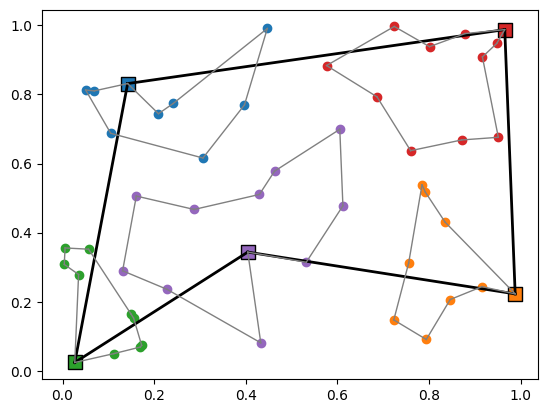

In [12]:
def run_inner_outer(vertices, cluster_assignments, selected_vertices, show_plot, print_log):
    path_data = []

    if show_plot:
        plot_clusters(vertices, cluster_assignments, selected_vertices)

    path_data.append(run_subTSP(selected_vertices, True, show_plot))
    if print_log:
        print('Center... done!')

    clusters = group_clusters(cluster_assignments, selected_vertices)

    for center in path_data[0][:-1]:
        if print_log:
            print('Size ', len(clusters[center]), '... ', sep='', end='')
        path_data.append(run_subTSP(clusters[center], False, show_plot))
        if print_log:
            print('done!')

    path_data = path_data[1:]

    if show_plot:
        plt.show()

    return path_data

path_data = run_inner_outer(vertices, cluster_assignments, selected_vertices, True, True)

## Step 3: Combine the Results

### Decide an Edge to Delete

For each edge in the cluster-level cycles, calculate **the distance from one end to the center of the previous cluster**, plus **the distance from the other end to the center of the next cluster**, and subtract **the length of the edge** to determine which edge to delete and how to connect to adjacent clusters.

In [13]:
# Function to calculate which edge to delete in the cluster cycle
def find_edge_to_delete(cycle, prev_center, next_center):
    min_total_distance = float('inf')
    edge_to_delete = None
    swap_order = None

    n = len(cycle)
    
    # Loop over all edges in the cycle.
    for i in range(n):
        start = cycle[i]
        end = cycle[(i + 1) % n]

        edge_length = start.distance_to(end)
        
        # Case 1: Original order (start -> end)
        dist_to_prev_center_case1 = start.distance_to(prev_center)
        dist_to_next_center_case1 = end.distance_to(next_center)
        total_distance_case1 = dist_to_prev_center_case1 + dist_to_next_center_case1 - edge_length
        
        # Case 2: Swapped order (end -> start)
        dist_to_prev_center_case2 = end.distance_to(prev_center)
        dist_to_next_center_case2 = start.distance_to(next_center)
        total_distance_case2 = dist_to_prev_center_case2 + dist_to_next_center_case2 - edge_length
        
        # Compare both cases and keep the best (minimum) one
        if total_distance_case1 < min_total_distance:
            min_total_distance = total_distance_case1
            edge_to_delete = i
            swap_order = False  # Indicates no swap in order
            
        if total_distance_case2 < min_total_distance:
            min_total_distance = total_distance_case2
            edge_to_delete = (i + 1) % n
            swap_order = True  # Indicates swap in order
    
    return edge_to_delete, swap_order

In [14]:
def run_deleteEdge(path_data):
    delete_edge = []

    for i in range(len(path_data)):
        edge_to_delete, swap_order = find_edge_to_delete(path_data[i], path_data[(i-1)%len(path_data)][0], path_data[(i+1)%len(path_data)][0])
        delete_edge.append((edge_to_delete, swap_order))

    actual_path = []

    for i in range(len(path_data)):
        path_data[i].pop()
        
        if delete_edge[i][1]:
            # Rotate to the right
            actual_path += path_data[i][delete_edge[i][0]:] + path_data[i][:delete_edge[i][0]]
        else:
            # Rotate to the left
            actual_path += path_data[i][delete_edge[i][0]::-1] + path_data[i][:delete_edge[i][0]:-1]
    
    return actual_path

actual_path = run_deleteEdge(path_data)

### Plot the Result

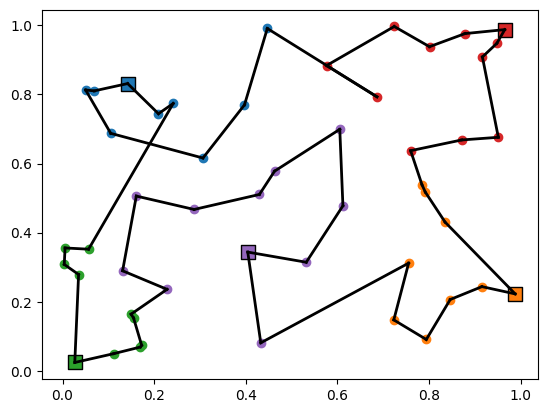

Distance: 6.739096074625648


In [15]:
def plot_final_path(vertices, cluster_assignments, selected_vertices, actual_path, show_plot):
    if show_plot:
        plot_clusters(vertices, cluster_assignments, selected_vertices)

        # Now plot the TSP route on top
        for i in range(len(actual_path)):
            start = actual_path[i]
            end = actual_path[(i + 1) % len(actual_path)]
            plt.plot([start.x, end.x], [start.y, end.y], color='black', linestyle='-', linewidth=2)
            
        plt.show()

    dist_sol = 0
    for i in range(len(actual_path)):
        dist_sol += actual_path[i].distance_to(actual_path[(i+1)%len(actual_path)])

    return dist_sol

dist_sol = plot_final_path(vertices, cluster_assignments, selected_vertices, actual_path, True)
print("Distance:", dist_sol)

### Compare with the Optimal Solution

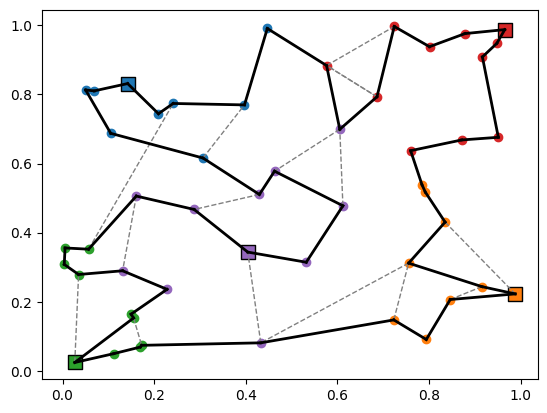

OPT = 6.019336206206333
SOL = 6.739096074625648
Rate = 1.119574624802847


In [16]:
def compare_solution(vertices, cluster_assignments, selected_vertices, actual_path, optimum, show_plot):
    if show_plot:
        plot_clusters(vertices, cluster_assignments, selected_vertices)

        # Now plot the TSP route on top
        for i in range(len(actual_path)):
            start = actual_path[i]
            end = actual_path[(i + 1) % len(actual_path)]
            plt.plot([start.x, end.x], [start.y, end.y], color='gray', linestyle='--', linewidth=1)

        # Now plot the TSP route on top
        for i in range(len(optimum)):
            start = optimum[i]
            end = optimum[(i + 1) % len(optimum)]
            plt.plot([start.x, end.x], [start.y, end.y], color='black', linestyle='-', linewidth=2)
            
        plt.show()

    dist_opt = 0
    for i in range(len(optimum)):
        dist_opt += optimum[i].distance_to(optimum[(i+1)%len(optimum)])
    return dist_opt

dist_opt = compare_solution(vertices, cluster_assignments, selected_vertices, actual_path, optimums[0], True)
print('OPT =', dist_opt)
print('SOL =', dist_sol)
print('Rate =', dist_sol/dist_opt)

## Step 4: Experiments

### Bringing Everything Together

In [17]:
def run_all(num_vertices, num_clusters, num_repeat, show_plot):
    data_path, num_clusters = set_parameters(num_vertices, num_clusters)
    test_cases, optimums = read_data(data_path, num_repeat)
    result = []
    for i in range(num_repeat):
        start_time = time.time()
        vertices, cluster_assignments, selected_vertices = run_clustering(test_cases[i], num_clusters, show_plot)
        path_data = run_inner_outer(vertices, cluster_assignments, selected_vertices, show_plot, False)
        actual_path = run_deleteEdge(path_data)
        end_time = time.time()
        dist_sol = plot_final_path(vertices, cluster_assignments, selected_vertices, actual_path, show_plot)
        dist_opt = compare_solution(vertices, cluster_assignments, selected_vertices, actual_path, optimums[i], show_plot)
        result.append((dist_sol, dist_opt, actual_path, optimums[i], end_time - start_time))
    return result

### Experiment 1: Find the Best Number of Clusters When `num_vertices=30`

In [18]:
num_vertices = 100
num_repeat = 3

for num_clusters in range(13, 18):
    result = run_all(num_vertices, num_clusters, num_repeat, False)
    sum_ratio, sum_time = 0, 0
    for i in result:
        sum_ratio += i[0]/i[1]
        sum_time += i[4]
    print(f"# of clusters: {num_clusters} => Avg ratio: {sum_ratio/num_repeat}, Avg time: {sum_time/num_repeat}")

# of clusters: 13 => Avg ratio: 1.2581007931098285, Avg time: 0.36803189913431805
# of clusters: 14 => Avg ratio: 1.2299004887854317, Avg time: 3.1733412742614746
# of clusters: 15 => Avg ratio: 1.2032409345927906, Avg time: 6.035442511240642
# of clusters: 16 => Avg ratio: 1.1892577738324335, Avg time: 1.4858769575754802
# of clusters: 17 => Avg ratio: 1.1855544298670273, Avg time: 3.400983969370524


### Experiment result:
The running time of the algorithm **HEAVILY** depends on the size of the largest cluster. My laptop cannot handle the traditional algorithm for solving the TSP on graphs with more than 20 vertices. I do not expect any other experiments to go well either. My next step should be to develop the algorithm to create clusters with the maximum possible size.